In [ ]:
import pandas as pd
import nltk
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, auc, roc_curve , classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.shape

In [3]:
train.iloc[1311,:]

tweet_id                                                  7701
tweet        False Alarm: Google Circles Not Coming NowÛÒa...
sentiment                                                    0
Name: 1311, dtype: object

In [4]:
train.isnull().sum()


tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [5]:
train.dropna(inplace=True)

In [6]:
train.iloc[1311,:]

tweet_id                                                  5260
tweet        RT @mention #sxsw @mention in her 80s splendor...
sentiment                                                    1
Name: 1312, dtype: object

In [7]:
train.isnull().sum()

tweet_id     0
tweet        0
sentiment    0
dtype: int64

In [8]:
train.shape

(7273, 3)

In [9]:
train.iloc[1311,:]

tweet_id                                                  5260
tweet        RT @mention #sxsw @mention in her 80s splendor...
sentiment                                                    1
Name: 1312, dtype: object

In [10]:
train.shape
train['sentiment']

0       1
1       1
2       2
3       0
4       1
5       1
6       1
7       1
8       2
9       2
10      3
11      2
12      2
13      1
14      1
15      1
16      1
17      2
18      1
19      1
20      1
21      1
22      2
23      2
24      0
25      1
26      1
27      1
28      3
29      1
       ..
7244    1
7245    2
7246    1
7247    1
7248    1
7249    1
7250    1
7251    1
7252    2
7253    1
7254    1
7255    2
7256    0
7257    1
7258    2
7259    2
7260    2
7261    2
7262    1
7263    2
7264    1
7265    2
7266    2
7267    3
7268    2
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7273, dtype: int64

In [11]:
#@mention // links // www. // n't // html encoding // lower

tok = nltk.tokenize.WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english') + list(punctuation)

custom = stop_words


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
def clean_tweet(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    words = [wordnet_lemmatizer.lemmatize(t) for t in words] #lemmatize words
    words = [t for t in words if not any(c.isdigit() for c in t)] # remove digits
    words = [t for t in words if t not in custom] #remove stopwords and punctuation


    return (" ".join(words)).strip()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bmasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bmasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
train.shape

(7273, 3)

In [13]:
cleaned_tweets = []
count=0
for tweet in train['tweet']:
    z=clean_tweet(tweet)
    if z != None:
        cleaned_tweets.append(clean_tweet(tweet))
    else:
        cleaned_tweets.append(np.nan)
        count+=1  
     

cleaned_df = pd.DataFrame(cleaned_tweets, columns=['text'])
cleaned_df['target'] = train.sentiment
cleaned_df = cleaned_df.dropna() # drop null records
cleaned_df.to_csv('cleaned_train.csv',encoding='utf-8')
print(len(cleaned_tweets))


7273


In [14]:
cleaned_df.shape

(7272, 2)

In [15]:
data=pd.read_csv("cleaned_train.csv")
data.tail()

,Unnamed: 0,text,target
7267,7268,google plze tammi middle sxsw craziness everyt...,2.0
7268,7269,rt set link edchat musedchat sxsw sxswi newtwi...,1.0
7269,7270,rt aha found proof lactation room excuse mothe...,1.0
7270,7271,launched ipad app sxsw get detail first editio...,1.0
7271,7272,next fin serv battle v apple goog mobile opera...,1.0


In [16]:
data.head()

,Unnamed: 0,text,target
0,0,sxswnui sxsw apple defining language touch dif...,1.0
1,1,learning ab google doodle doodle light funny i...,1.0
2,2,one face ex stealing show yr rt sxsw apple sch...,2.0
3,3,iphone sxsw app would pretty awesome crash eve...,0.0
4,4,line outside apple store austin waiting new ip...,1.0


In [17]:
data.drop(data.columns[0],axis=1,inplace=True)

In [18]:
new = pd.DataFrame(data.text.str.split(expand=True).stack().value_counts())
new.reset_index(level=0, inplace=True)
new.columns = ['word', 'freq']
new = new[(new['freq'] >=200)]
new.drop(38,inplace=True)
new.drop(36,inplace=True)
new.drop(27,inplace=True)
new.drop(8,inplace=True)
new.drop(21,inplace=True)
new.drop(22,inplace=True)
new.drop(35,inplace=True)



new


,word,freq
0,sxsw,7727
1,link,3453
2,ipad,2395
3,rt,2378
4,google,2113
5,apple,1888
6,iphone,1281
7,store,1236
9,austin,795
10,app,672


In [19]:
d = dict(zip(new['word'], new['freq']))

In [20]:
def check_thresh_word(merc,d):
    m = merc.split(' ')
    for i in range(len(m)):
            if m[i] in d.keys():
                return False
    else:
        return True

def rm_freq_occurences(merc,d):
    if check_thresh_word(merc,d) == False:
        nwords = merc.split(' ')
        rwords = [word for word in nwords if word not in d.keys()]
        m = ' '.join(rwords)
    else:
        m=merc
    return m

data['new'] = data['text'].apply(lambda x: rm_freq_occurences(x,d))

In [21]:
data.drop(['text'],axis=1,inplace=True)


In [22]:
data

,target,new
0,1.0,sxswnui defining language touch different dial...
1,1.0,learning ab doodle doodle light funny innovati...
2,2.0,face ex stealing show yr school mkt expert
3,0.0,would pretty awesome crash every min extended ...
4,1.0,outside waiting new
5,1.0,technews lone dude awaits tech news tablet tech
6,1.0,tip prince npr video toy shopping zuckerberg
7,1.0,nu user new ubersocial includes uberguide spon...
8,2.0,free sampler itunes freemusic
9,2.0,think might weekend without seeing case twice


In [23]:
data.head()

,target,new
0,1.0,sxswnui defining language touch different dial...
1,1.0,learning ab doodle doodle light funny innovati...
2,2.0,face ex stealing show yr school mkt expert
3,0.0,would pretty awesome crash every min extended ...
4,1.0,outside waiting new


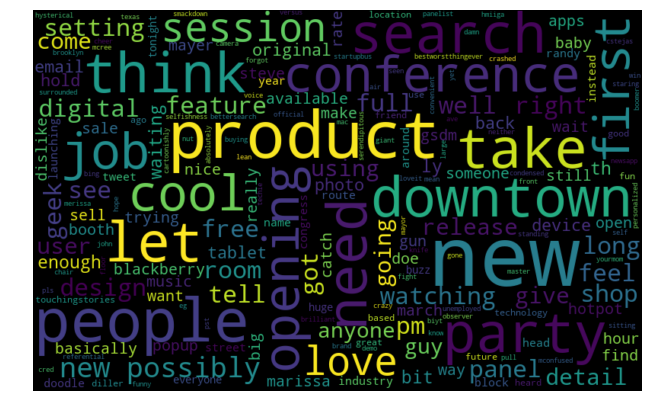

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 3]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

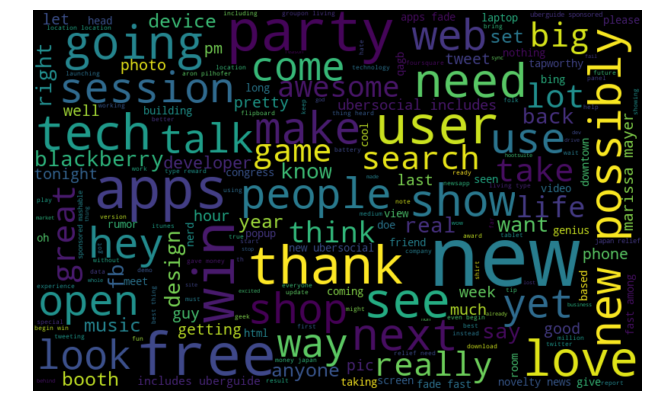

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 0]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

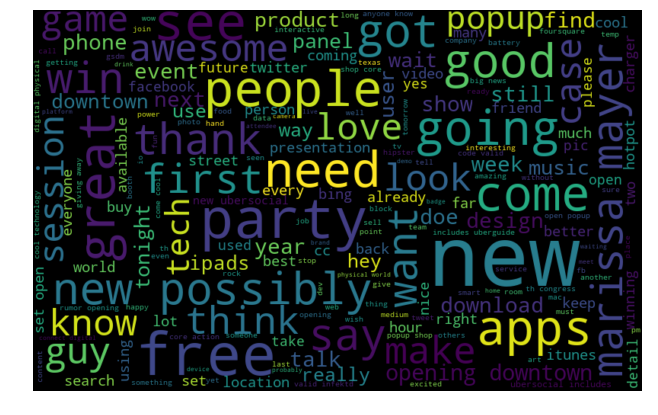

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 2]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

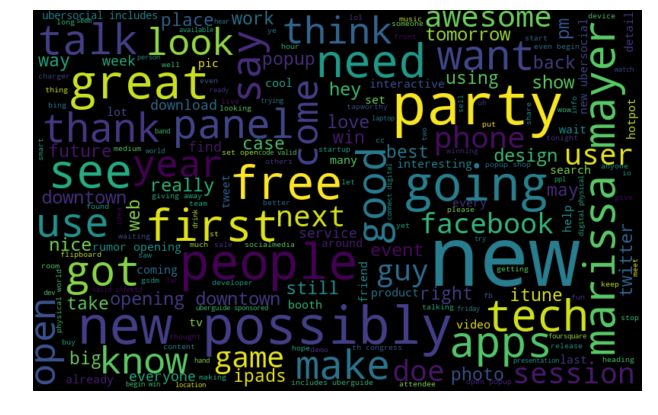

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Positive Sentiment
pos_words = ' '.join([text for text in data['new'][data['target'] == 1]])

# generate wordcloud object for positive sentiments
pos_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(15, 7))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [28]:
data.rename(columns= {"new":"tweet"},inplace=True)
data.to_csv("finaldata.csv")


In [29]:
data.head()

,target,tweet
0,1.0,sxswnui defining language touch different dial...
1,1.0,learning ab doodle doodle light funny innovati...
2,2.0,face ex stealing show yr school mkt expert
3,0.0,would pretty awesome crash every min extended ...
4,1.0,outside waiting new


In [30]:
X=data['tweet']
y=data['target']

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")

In [32]:
X=tfidf.fit_transform(X)
X = X.toarray()


In [33]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)


In [34]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
y_pred=nb.predict(X_test)
y_pred

array([0., 3., 2., ..., 1., 1., 3.])

In [35]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='weighted')  


0.3650914673941298

In [36]:
print (classification_report(y_test,y_pred))


              precision    recall  f1-score   support

         0.0       0.08      0.21      0.11       130
         1.0       0.59      0.30      0.40      1302
         2.0       0.32      0.44      0.37       718
         3.0       0.01      0.06      0.02        32

    accuracy                           0.34      2182
   macro avg       0.25      0.25      0.22      2182
weighted avg       0.46      0.34      0.37      2182



In [37]:
from sklearn.naive_bayes import MultinomialNB

mb=MultinomialNB()
mb.fit(X_train,y_train)
y_pred=mb.predict(X_test)
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [38]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.60      0.96      0.73      1302
         2.0       0.29      0.04      0.06       718
         3.0       0.00      0.00      0.00        32

    accuracy                           0.58      2182
   macro avg       0.22      0.25      0.20      2182
weighted avg       0.45      0.58      0.46      2182



D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
# from sklearn.svm import SVC, LinearSVC
# clf1 = SVC(kernel='linear') #Sequential
# clf1.fit(X_train, y_train)
# clf3 = LinearSVC(class_weight='balanced')

In [40]:
# Perform classification with SVM, kernel=linear
from sklearn import svm
from sklearn.metrics import classification_report

classifier_linear = svm.SVC(kernel='linear',class_weight='balanced')
t0 = time.time()
classifier_linear.fit(X_train,y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test,y_pred, output_dict=True)
# print('positive: ', report['pos'])
# print('negative: ', report['neg'])


Training time: 311.058411s; Prediction time: 88.783648s


D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
print( classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.60      0.96      0.73      1302
         2.0       0.29      0.04      0.06       718
         3.0       0.00      0.00      0.00        32

    accuracy                           0.58      2182
   macro avg       0.22      0.25      0.20      2182
weighted avg       0.45      0.58      0.46      2182



In [42]:
clf_model = LogisticRegression()
clf = clf_model.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average=None)

D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Accuracy: 0.5870760769935839


D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.73386384, 0.06427689, 0.        ])

In [43]:
print( classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.60      0.96      0.73      1302
         2.0       0.29      0.04      0.06       718
         3.0       0.00      0.00      0.00        32

    accuracy                           0.58      2182
   macro avg       0.22      0.25      0.20      2182
weighted avg       0.45      0.58      0.46      2182



D:\Data_Science\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
